Authors:
* Duhr Łukasz, indeks: 136700
* Komkowska Ewa, indeks: 136737

## Loading from file

### Install libraries and read files

In [1]:
!pip install tspy
!pip install TSPLib95

import tsplib95
import numpy as np
import matplotlib.pyplot as plt
from tspy import TSP
from random import randint
import time

In [2]:
tsp = TSP()

kroAProblem = tsplib95.load('kroA200.tsp')
kroBProblem = tsplib95.load('kroB200.tsp')

kroAData = kroAProblem.as_name_dict()['node_coords']
kroBData = kroBProblem.as_name_dict()['node_coords']

verticesA = [kroAData[key] for key in kroAData]
verticesB = [kroBData[key] for key in kroBData]

### Convert data to distance matrix

In [3]:
def distance_matrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]

  return np.array(outputMatrix)

In [4]:
print(distance_matrix(verticesA))
print(distance_matrix(verticesB))

[[   0 1700 1846 ...  452 1163 2616]
 [1700    0 1118 ... 1250 2651 1504]
 [1846 1118    0 ... 1536 2320 2615]
 ...
 [ 452 1250 1536 ...    0 1535 2228]
 [1163 2651 2320 ... 1535    0 3760]
 [2616 1504 2615 ... 2228 3760    0]]
[[   0 2607  549 ... 1240 1232 3117]
 [2607    0 3154 ... 3442 1644  933]
 [ 549 3154    0 ... 1097 1713 3658]
 ...
 [1240 3442 1097 ...    0 2398 3680]
 [1232 1644 1713 ... 2398    0 2406]
 [3117  933 3658 ... 3680 2406    0]]


## Algorithms - exercise 1 - Greedy cycle, Heuristic

### Utility


In [5]:
def choose_nearest(matrix, invited_vertices, node):
  return np.argmin([matrix[node][i] if i not in invited_vertices and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [6]:
def calculate_cycle_length(matrix, visited):
  sum = 0
  for graph in visited:
    sum += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])
  return sum

In [7]:
def draw_plot(vertices, visited):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  plt.show()

### Greedy algorithm (using nearest neighbor)

In [8]:
def greedy_nearest_neighbor(distance_matrix, start_node_1):

  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  visited_1 = [node_1]
  visited_2 = [node_2]

  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    if len(visited_1) <= len(visited_2):
      vertex = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_1)
      visited_1.append(vertex)
      node_1 = vertex
    else:
      vertex = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_2)
      visited_2.append(vertex)
      node_2 = vertex

  visited_1.append(visited_1[0])
  visited_2.append(visited_2[0])

  return visited_1, visited_2

  # sum of both cycle
  # print(sum([(matrix[elem][visited_1[i+1]]) for i, elem in enumerate(visited_1[:-1])]) + sum([(matrix[elem][visited_1[i+1]]) for i, elem in enumerate(visited_1[:-1])]))

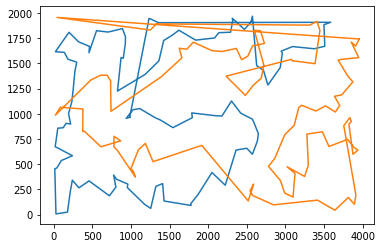

In [9]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
# draw_plot(matrix, [visited_1, visited_2])
draw_plot(verticesA, [visited_1, visited_2])

### Greedy algorithm (using greedy cycle)

In [10]:
def greedy_cycle(matrix, start_node_1):
  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  # Choose nearest vertices
  min_node_1 = choose_nearest(matrix, [node_1, node_2], node_1)
  min_node_2 = choose_nearest(matrix, [node_1, node_2, min_node_1], node_2)

  visited_1 = [node_1, min_node_1, node_1]
  visited_2 = [node_2, min_node_2, node_2]

  # Find min length in visited vertices until visited all
  while len(np.concatenate([visited_1, visited_2])) != len(matrix) + 2:
    min_value = np.inf
    min_index = np.inf
    min_closest_index = np.inf

    visited_list = visited_1 if len(visited_1) <= len(visited_2) else visited_2

    for index in range(len(visited_list) - 1):
      closest = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), visited_list[index])
      for index_2 in range(len(visited_list) - 1):

        fix = matrix[visited_list[index_2], closest] + matrix[visited_list[index_2 + 1], closest] - matrix[visited_list[index_2], visited_list[index_2 + 1]]
        if (fix < min_value):
          min_value = fix
          min_index = index_2 + 1
          min_closest_index = closest

    if len(visited_1) <= len(visited_2):
      visited_1 = np.insert(visited_list, min_index, min_closest_index)
    else:
      visited_2 = np.insert(visited_list, min_index, min_closest_index)

  return visited_1, visited_2

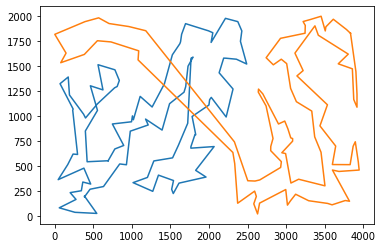

In [11]:
matrix = distance_matrix(verticesB)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_cycle(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
# draw_plot(matrix, [visited_1, visited_2])
draw_plot(verticesB, [visited_1, visited_2])

### Regret heuristic (using 2-regret)

In [12]:
from heapq import nsmallest

def greedy_regret(matrix, start_node_1):
  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  # Check as visited
  visited_1 = [node_1]
  visited_2 = [node_2]

  # Choose nearest vertices
  min_node_1 = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_1)
  visited_1.append(min_node_1)

  min_node_2 = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_2)
  visited_2.append(min_node_2)

  visited_1.append(node_1)
  visited_2.append(node_2)

  # print(visited_1, visited_2)


  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    max_regret = -float('inf') 
    regret_vertice = None

    visited_list = visited_1 if len(visited_1) <= len(visited_2) else visited_2
    start_regret_first = None
    start_regret_second = None

    for index in range(len(matrix)):
      if index not in np.concatenate([visited_1, visited_2]):
        cost_list = []
        for visited_index, visited_vertex in enumerate(visited_list):
          if visited_index + 1 < len(visited_list):
            cost_list.append(matrix[index][visited_vertex] + matrix[index][visited_list[visited_index + 1]] - matrix[visited_vertex][visited_list[visited_index + 1]])
        
        if start_regret_first is None:
          start_regret_first = np.argmin(cost_list)
          start_regret_second = cost_list.index(nsmallest(2, cost_list)[-1])

        if cost_list[start_regret_first] - cost_list[start_regret_second] > max_regret: 
          regret_vertice = index
          max_regret = cost_list[start_regret_first] - cost_list[start_regret_second]

    min_route = np.inf
    index_from = None
    for index, vertex in enumerate(visited_list):
      if index + 1 < len(visited_list) and matrix[regret_vertice][vertex] + matrix[regret_vertice][visited_list[index + 1]] < min_route:
        min_route = matrix[regret_vertice][vertex] + matrix[regret_vertice][visited_list[index + 1]]
        index_from = index + 1
      
    if len(visited_1) <= len(visited_2):
        visited_1.insert(index_from, regret_vertice)
    else:
        visited_2.insert(index_from, regret_vertice)
    
  return visited_1, visited_2

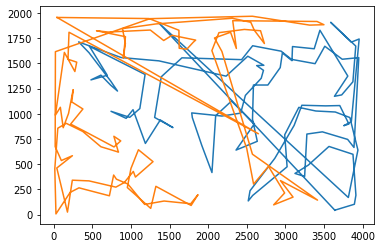

In [13]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_regret(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
# draw_plot(matrix, [visited_1, visited_2])
draw_plot(verticesA, [visited_1, visited_2])

## Poprawiony regret

37039


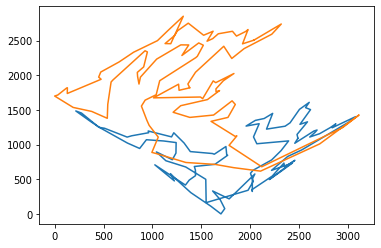

In [14]:
def calculate_score(vertices, distance_matrix):
    score = 0
    for i in range(len(vertices) - 1):
        score += distance_matrix[vertices[i]][vertices[i+1]]
    if len(vertices) > 2:
        score += distance_matrix[vertices[0]][vertices[-1]]
    return score

def get_best_insertion(visited_1, visited_2, matrix):
    best_score = np.inf
    best_vertex = None
    best_index = None

    for vertex in range(len(matrix)):
        if vertex in np.concatenate([visited_1, visited_2]):
            continue
        for position in range(len(visited_1) + 1):
            temp_vertices = np.copy(visited_1).tolist()
            temp_vertices.insert(position, vertex)
            score = calculate_score(temp_vertices, matrix)

            if score < best_score:
                best_score = score
                best_vertex = vertex
                best_index = position

    return best_vertex, best_index, best_score

def regret_heuristics_2(distance_matrix, start_vertex=0):
    visited_1 = [start_vertex]
    visited_2 = [np.argmax(matrix[start_vertex])]

    for iteration in range(len(distance_matrix) - 4):
        if iteration % 2 == 0:
            visited, visited_t = visited_1, visited_2
        else:
            visited, visited_t = visited_2, visited_1

        temp1 = np.copy(visited).tolist()
        best_vertex_1, best_index_1, _ = get_best_insertion(temp1, visited_t, distance_matrix)
        temp1.insert(best_index_1, best_vertex_1)

        best_vertex_2, best_index_2, _ = get_best_insertion(temp1, visited_t, distance_matrix)
        temp1.insert(best_index_2, best_vertex_2)

        temp2 = np.copy(visited).tolist()
        temp2.insert(best_index_2, best_vertex_2)
        temp2.insert(best_index_1, best_vertex_1)

        if calculate_score(temp2, distance_matrix) < calculate_score(temp1, distance_matrix):
            visited.insert(best_index_2, best_vertex_2)
        else:
            visited.insert(best_index_1, best_vertex_1)

    for i in range(len(distance_matrix)):
        if i not in np.concatenate([visited_1, visited_2]):
            if len(visited_1) % 2 != 0:
                best_vertex, best_index, _ = get_best_insertion(visited_1, visited_2, distance_matrix)
                visited_1.insert(best_index, best_vertex)
            else:
                best_vertex, best_index, _ = get_best_insertion(visited_2, visited_1, distance_matrix)
                visited_2.insert(best_index, best_vertex)

    visited_1.append(visited_1[0])
    visited_2.append(visited_2[0])
    
    return visited_1, visited_2
    
matrix = distance_matrix(verticesA)
start_node = 27

visited_1, visited_2 = regret_heuristics_2(matrix.tolist(), start_node)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
print(sum)
draw_plot(matrix, [visited_1, visited_2])
# 27 26974

## Algorithms - exercise 2 - Local Search

### Greedy algorithm (changed vertices)

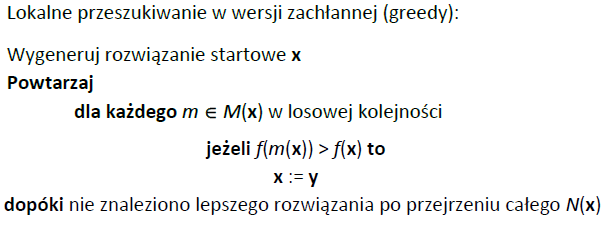

In [15]:
def look_in_one_list(visited, index, vertice):
  start_solution_sum = calculate_cycle_length(matrix, [visited])
  final_solution_sum = start_solution_sum

  for index_2 in range(1, len(visited) - 1):
    vertice_2 = visited[index_2]
    if abs(index - index_2) >= 1: 
      if abs(index - index_2) == 1:
        if index > index_2:
          delta = matrix[visited[index_2 - 1]][vertice_2] + matrix[visited[index + 1]][vertice] - (matrix[visited[index_2 - 1]][vertice] + matrix[visited[index + 1]][vertice_2])
        else:
          delta = matrix[visited[index_2 + 1]][vertice_2] + matrix[visited[index - 1]][vertice] - (matrix[visited[index_2 + 1]][vertice] + matrix[visited[index - 1]][vertice_2])
      else:
        # TODO: tutaj się wywala za kazdym razem...
        delta = matrix[visited[index - 1]][vertice] + matrix[visited[index + 1]][vertice] + matrix[visited[index_2 - 1]][vertice_2] + matrix[visited[index_2 + 1]][vertice_2] - (matrix[visited[index - 1]][vertice_2] + matrix[visited[index + 1]][vertice_2] + matrix[visited[index_2 - 1]][vertice] + matrix[visited[index_2 + 1]][vertice])

      if delta > 0:
        final_solution_sum -= delta
        visited[index] = vertice_2
        visited[index_2] = vertice
        vertice = vertice_2

    elif index == 0 and index_2 != index:
      delta = matrix[visited[index - 2]][vertice] + matrix[visited[index + 1]][vertice] + matrix[visited[index_2 - 1]][vertice_2] + matrix[visited[index_2 + 1]][vertice_2] - (matrix[visited[index - 2]][vertice_2] + matrix[visited[index + 1]][vertice_2] + matrix[visited[index_2 - 1]][vertice] + matrix[visited[index_2 + 1]][vertice])

      if delta > 0:
        final_solution_sum -= delta
        visited[index_2] = vertice
        visited[0] = vertice_2
        visited[len(visited) - 1] = vertice_2
        vertice = vertice_2

  return visited


In [16]:
def greedy_change_vertices(matrix, visited_1, visited_2):
  start_solution_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  final_solution_sum = start_solution_sum
  changed = []

  final_visited_1 = visited_1
  final_visited_2 = visited_2

  while final_solution_sum >= start_solution_sum and len(changed) < len(final_visited_1) - 3:
      change_index = randint(0, len(final_visited_1) - 3)

      while final_visited_1[change_index] in changed:
        change_index = randint(0, len(final_visited_1) - 3)
      
      start_vertice = final_visited_1[change_index]
      previous_change_index = change_index - 1 if change_index > 0 else change_index - 2
      changed.append(start_vertice) 
      
      final_visited_1 = look_in_one_list(final_visited_1, change_index, start_vertice)

      if change_index < len(final_visited_2):
        final_visited_2 = look_in_one_list(final_visited_2, change_index, final_visited_2[change_index])
      
      final_solution_sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

      for index in range(len(final_visited_2)):
        vertice = final_visited_2[index]
        if index + 1 < len(final_visited_2) and index > 0 and change_index > 0:
          delta = matrix[final_visited_2[index - 1]][vertice] + matrix[final_visited_2[index + 1]][vertice] + \
           matrix[final_visited_1[previous_change_index]][start_vertice] + matrix[final_visited_1[change_index + 1]][start_vertice] - \
           (matrix[final_visited_2[index - 1]][start_vertice] + matrix[final_visited_2[index + 1]][start_vertice] + \
            matrix[final_visited_1[previous_change_index]][vertice] + matrix[final_visited_1[change_index + 1]][vertice])

          if delta > 0:
            final_solution_sum -= delta
            final_visited_1[change_index] = vertice
            final_visited_2[index] = start_vertice
            start_vertice = vertice

        elif index == 0 and change_index > 0:
          delta = matrix[final_visited_2[-2]][vertice] + matrix[final_visited_2[1]][vertice] + \
          matrix[final_visited_1[previous_change_index]][start_vertice] + matrix[final_visited_1[change_index + 1]][start_vertice] - \
          (matrix[final_visited_2[index - 2]][start_vertice] + matrix[final_visited_2[index + 1]][start_vertice] + \
           matrix[final_visited_1[previous_change_index]][vertice] + matrix[final_visited_1[change_index + 1]][vertice])

          if delta > 0:
            final_solution_sum -= delta
            final_visited_1[change_index] = vertice
            final_visited_2[0] = start_vertice
            final_visited_2[len(final_visited_2) - 1] = start_vertice
            start_vertice = vertice

        elif change_index == 0 and index + 1 < len(final_visited_2):
          delta = matrix[final_visited_2[index - 1]][vertice] + matrix[final_visited_2[index + 1]][vertice] + matrix[final_visited_1[change_index - 2]][start_vertice] + matrix[final_visited_1[change_index + 1]][start_vertice] - (matrix[final_visited_2[index - 1]][start_vertice] + matrix[final_visited_2[index + 1]][start_vertice] + matrix[final_visited_1[change_index - 2]][vertice] + matrix[final_visited_1[change_index + 1]][vertice]) 

          if delta > 0:
            final_solution_sum -= delta
            final_visited_2[index] = start_vertice
            final_visited_1[0] = vertice
            final_visited_1[len(final_visited_1) - 1] = vertice  
            start_vertice = vertice

  return final_visited_1, final_visited_2


len of list: 202


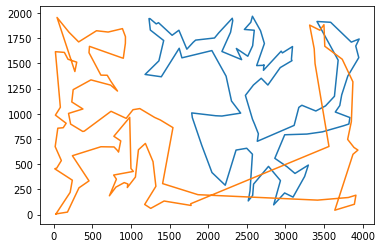

100 100
delta: 159 , len of final_visited_1: 101 , len of final_visited_2: 101


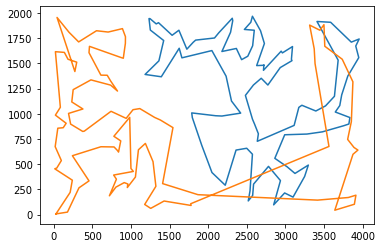

In [17]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

# TODO: czasem wyrzuca 102 wierzchołki - wejściowo 102 - jakim cudem - w greedy_nearest_neighbor
# visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
# visited_1, visited_2 = greedy_regret(matrix, start_node_1)
visited_1, visited_2 = greedy_cycle(matrix, start_node_1)

start_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
print('len of list:', len(np.concatenate([visited_1, visited_2])))
# draw_plot(matrix, [visited_1, visited_2])
draw_plot(verticesA, [visited_1, visited_2])

# dla greedy_cycle:
final_visited_1, final_visited_2 = greedy_change_vertices(matrix, visited_1.tolist(), visited_2.tolist())
# final_visited_1, final_visited_2 = greedy_change_vertices(matrix, visited_1, visited_2)
sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

print(len(set(final_visited_1)), len(set(final_visited_2)))
print('delta:', start_sum - sum, ', len of final_visited_1:', len(final_visited_1),  ', len of final_visited_2:', len(final_visited_2))
# draw_plot(matrix, [final_visited_1, final_visited_2])
draw_plot(verticesA, [final_visited_1, final_visited_2])

### Greedy algorithm (changed edges)

In [18]:
def change_edges_in_one(matrix, visited):
  changed = []
  start_solution_sum = calculate_cycle_length(matrix, [visited])
  final_solution_sum = start_solution_sum

  while final_solution_sum >= start_solution_sum and len(changed) < len(visited) - 2:
    start_index_1 = randint(1, len(visited) - 1)

    while visited[start_index_1] in changed:
      start_index_1 = randint(1, len(visited) - 1)
      
    start_vertice = visited[start_index_1]
    start_index_2 = start_index_1 + 1 if start_index_1 < len(visited) - 1 else 1
    start_vertice_2 = visited[start_index_2]
    changed.append(start_vertice) 

    for index in range(len(visited) - 2):
      change_index_2 = index + 2
      change_index_1 = index + 1
      vertice = visited[change_index_1]
      vertice_2 = visited[change_index_2]

      if change_index_2 != start_index_1 and change_index_2 != start_index_2 and change_index_1 != start_index_2:
        # zamień teraz te krawędzie 
        delta = matrix[start_vertice][start_vertice_2] + matrix[vertice][vertice_2] - (matrix[start_vertice][vertice] + matrix[start_vertice_2][vertice_2])

        if delta > 0:
          if start_index_2 < change_index_1:
            # print('1:', visited)
            visited[start_index_2] = vertice
            visited[start_index_2 + 1:change_index_1] = list(reversed(visited[start_index_2 + 1:change_index_1]))
            visited[change_index_1] = start_vertice_2
            final_solution_sum -= delta
            start_vertice_2 = visited[start_index_2]
            start_vertice = visited[start_index_1]

          else:
            visited[change_index_2] = start_vertice
            visited[change_index_2+1:start_index_1] = list(reversed(visited[change_index_2+1:start_index_1]))
            visited[start_index_1] = vertice_2 
            final_solution_sum -= delta
            start_vertice_2 = visited[start_index_2]
            start_vertice = visited[start_index_1]
            
  return visited

In [19]:
def greedy_change_edges(matrix, visited_1, visited_2):

  final_visited_1 = change_edges_in_one(matrix, visited_1)
  final_visited_2 = change_edges_in_one(matrix, visited_2)

  return final_visited_1, final_visited_2


len of list: 202


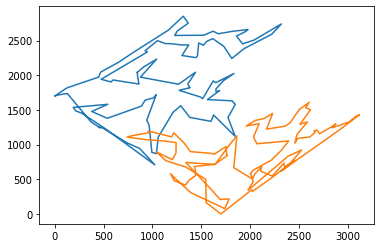

delta: 63


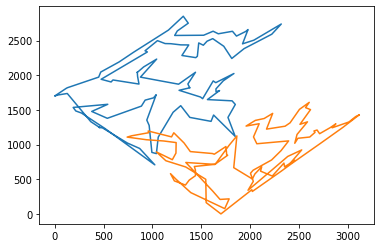

In [20]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

# visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
# visited_1, visited_2 = greedy_regret(matrix, start_node_1)
visited_1, visited_2 = greedy_cycle(matrix, start_node_1)

start_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
print('len of list:', len(np.concatenate([visited_1, visited_2])))
draw_plot(matrix, [visited_1, visited_2])

# dla greedy_cycle:
# final_visited_1, final_visited_2 = greedy_change_edges(matrix, visited_1.tolist(), visited_2.tolist())
final_visited_1, final_visited_2 = greedy_change_edges(matrix, visited_1, visited_2)
sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

print('delta:', start_sum - sum)
# print('len of list:', len(np.concatenate([visited_1, visited_2])), ', len of set final_visited_1:', len(set(final_visited_1)),  ', len of set final_visited_2:', len(set(final_visited_2)))
draw_plot(matrix, [final_visited_1, final_visited_2])

### Steepest algorithm

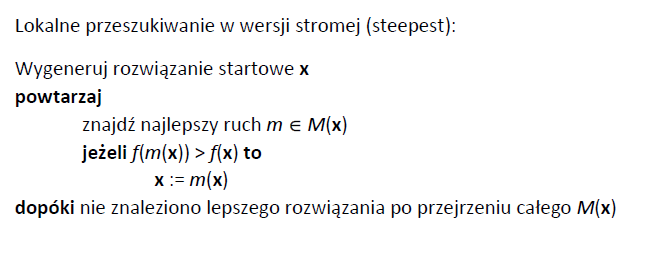

#### Zamiana wierzhołków MIĘDZY grafami


In [21]:
# zamiana wierzhołków MIĘDZY grafami
def steepest_change_vertices_outer(matrix, visited_1, visited_2):
  best = -np.inf
  vertex_to_change = []
  for first in range(len(visited_1) - 1):
    for second in range(len(visited_2) - 1):
      first_pre,first_next = first-1,first+1
      second_pre,second_next = second-1,second+1
      if (first == 0):
        first_pre = first-2
      if (second == 0):
        second_pre = second-2
      previous = matrix[visited_1[first], visited_1[first_pre]] +\
                 matrix[visited_1[first], visited_1[first_next]] +\
                 matrix[visited_2[second], visited_2[second_pre]] +\
                 matrix[visited_2[second], visited_2[second_next]]
      next = matrix[visited_2[second], visited_1[first_pre]] +\
             matrix[visited_2[second], visited_1[first_next]] +\
             matrix[visited_1[first], visited_2[second_pre]] +\
             matrix[visited_1[first], visited_2[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        vertex_to_change = [visited_1[first], visited_2[second]]
  # print('Best delta:',best)
  
  if (best <= 0):
    return
  visited_1[visited_1 == vertex_to_change[0]] = vertex_to_change[1]
  visited_2[visited_2 == vertex_to_change[1]] = vertex_to_change[0]

#### Zamiana wierzchołków WEWNĄTRZ grafu

In [22]:
# zamiana wierzhołków WEWNĄTRZ grafu
def steepest_change_vertices_inner(matrix, visited):
  best = -np.inf
  vertex_to_change = []
  for first in range(len(visited) - 2):
    for second in range(first + 1, len(visited) - 1):
      first_pre,first_next = first-1,first+1
      second_pre,second_next = second-1,second+1
      if (first == 0):
        first_pre = first-2
      if (first_next == second): # warunek sąsiedztwa
        previous = matrix[visited[first], visited[first_pre]] +\
                  matrix[visited[first], visited[second]] +\
                  matrix[visited[second], visited[first]] +\
                  matrix[visited[second], visited[second_next]]
        next = matrix[visited[second], visited[first_pre]] +\
              matrix[visited[second], visited[first]] +\
              matrix[visited[first], visited[second]] +\
              matrix[visited[first], visited[second_next]]
      else:
        previous = matrix[visited[first], visited[first_pre]] +\
                  matrix[visited[first], visited[first_next]] +\
                  matrix[visited[second], visited[second_pre]] +\
                  matrix[visited[second], visited[second_next]]
        next = matrix[visited[second], visited[first_pre]] +\
              matrix[visited[second], visited[first_next]] +\
              matrix[visited[first], visited[second_pre]] +\
              matrix[visited[first], visited[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        vertex_to_change = [visited[first], visited[second]]
  # print(calculate_cycle_length(matrix,[visited]))
  # print('Best delta:',best,'(',calculate_cycle_length(matrix,[visited]),')')
  if (best <= 0):
    return

  visited[visited == vertex_to_change[0]] = vertex_to_change[1]
  visited[visited == vertex_to_change[1]] = vertex_to_change[0]
  # print('Best delta:',best,'(',calculate_cycle_length(matrix,[visited]),')')

#### Zamiana krawędzi WEWNĄTRZ grafu

In [23]:
# zamiana krawędzi WEWNĄTRZ grafu
def steepest_change_edges_inner(matrix, visited):
  best = -np.inf
  index_to_change = []
  for first in range(len(visited) - 2):
    for second in range(first + 2, len(visited) - 1):
      first_next = first+1
      second_next = second+1
      if (visited[first] == visited[second_next]):
        continue

      previous = matrix[visited[first], visited[first_next]] +\
                matrix[visited[second], visited[second_next]]
      next = matrix[visited[first], visited[second]] +\
            matrix[visited[first_next], visited[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        index_to_change = [first_next, second]
  # print('Vertexes to change:',visited[index_to_change[0]],visited[index_to_change[1]])
  # print('Best delta:',best,'(',calculate_cycle_length(matrix,[visited]),')')
  if (best <= 0):
    return
  visited[visited == visited[index_to_change[0]]] = visited[index_to_change[1]]
  visited[visited == visited[index_to_change[1]]] = visited[index_to_change[0]]
  visited[index_to_change[0]+1:index_to_change[1]] = visited[index_to_change[0]+1:index_to_change[1]][::-1]
  # print('Best delta:',best,'(',calculate_cycle_length(matrix,[visited]),')')

#### algorytm v.1
1. inner vertices one
2. inner vertices two
3. outer vertices

In [24]:
def steepest_change_vertices(matrix, visited_1, visited_2):
  # inner graph 1
  # print('inner vert one')
  while True:
    previous = calculate_cycle_length(matrix,[visited_1])
    steepest_change_vertices_inner(matrix, visited_1)
    next = calculate_cycle_length(matrix,[visited_1])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

  # print('inner vert two')
  # inner graph 2
  while True:
    previous = calculate_cycle_length(matrix,[visited_2])
    steepest_change_vertices_inner(matrix, visited_2)
    next = calculate_cycle_length(matrix,[visited_2])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

  # print('outer vert')
  # outer graphs
  while True:
    previous = calculate_cycle_length(matrix,[visited_1,visited_2])
    steepest_change_vertices_outer(matrix, visited_1, visited_2)
    next = calculate_cycle_length(matrix,[visited_1,visited_2])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

#### algorytm v.2
1. inner edge one
2. inner edge two
3. outer vertices

In [25]:
def steepest_change_edges(matrix, visited_1, visited_2):
  # inner graph 1
  # print('inner edge one')
  while True:
    previous = calculate_cycle_length(matrix,[visited_1])
    steepest_change_edges_inner(matrix, visited_1)
    next = calculate_cycle_length(matrix,[visited_1])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

  # print('inner edge two')
  # inner graph 2
  while True:
    previous = calculate_cycle_length(matrix,[visited_2])
    steepest_change_edges_inner(matrix, visited_2)
    next = calculate_cycle_length(matrix,[visited_2])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

  # print('outer vert')
  # outer graphs
  while True:
    previous = calculate_cycle_length(matrix,[visited_1,visited_2])
    steepest_change_vertices_outer(matrix, visited_1, visited_2)
    next = calculate_cycle_length(matrix,[visited_1,visited_2])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

#### Testing


In [26]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_cycle(matrix, start_node_1)

print('delta_pre:',calculate_cycle_length(matrix,[visited_1,visited_2]))

steepest_change_edges(matrix, visited_1, visited_2)
# steepest_change_vertices(matrix, visited_1, visited_2)

print('delta_post:',calculate_cycle_length(matrix,[visited_1,visited_2]))

# draw_plot(matrix, [final_visited_1, final_visited_2])

delta_pre: 35944
delta_post: 35485


### Random algorithm

In [27]:
def generate_random(matrix, start_vertex):
  final = [start_vertex]

  while (len(final) < len(matrix)):
    check_index = randint(0, len(matrix) - 1)

    if not check_index in final:
      final.append(check_index)

  final_first = int((len(matrix) + 1) / 2)
  return np.array(final[0:final_first] + [start_vertex]), np.array(final[final_first:] + [final[final_first]])

visited_1, visited_2 = generate_random(matrix, 14)

## Algorithms - Exercise 3 - Faster Steepest Local Search

### Helper functions

In [28]:
''' Struktura przechowywania danych
  {
    'wartość_ulepszenia': [
      [wierzchołek_1, wierzchołek_2],
      [wierzchołek_1, wierzchołek_2, wierzchołek_3, wierzchołek_4], # krawędziowe - pierwsza i druga, 1 z 4, 2 z 3
  ] '''

def sort_dict(mydict, rev = True):
  final = {}
  for key in sorted(mydict, reverse=rev):
    final[key] = mydict[key]
  return final

def check_for_change_vertices_in_one(matrix, visited):
  final_dictionary = { }
  
  for index, item in enumerate(visited[1:-1]):
    for next_index, next_item in enumerate(visited[index + 2:-1]):
      previous = matrix[item][visited[index + 1]] + matrix[next_item][visited[next_index + 1]] + \
        matrix[item][visited[index - 1]] + matrix[next_item][visited[next_index - 1]]

      next = matrix[item][visited[next_index + 1]] + matrix[next_item][visited[index + 1]] + \
        matrix[item][visited[next_index - 1]] + matrix[next_item][visited[index - 1]]

      delta = previous - next
      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([item, next_item])
        else:
          final_dictionary[delta] = [[item, next_item]]

  return sort_dict(final_dictionary)


def check_for_change_edges_in_one(matrix, visited):
  final_dictionary = { }
  
  for index, item in enumerate(visited[1:-1]):
    for next_index, next_item in enumerate(visited[index + 1:-1]):
      previous = matrix[item][visited[index + 1]] + matrix[next_item][visited[next_index + 1]]

      next = matrix[item][next_item] + matrix[visited[next_index + 1]][visited[index + 1]]

      delta = previous - next
      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([item, visited[index + 1], next_item, visited[next_index + 1]])
        else:
          final_dictionary[delta] = [[item, visited[index + 1], next_item, visited[next_index + 1]]]

  return sort_dict(final_dictionary)


def check_for_change_vertices(matrix, visited_1, visited_2):
  final_dictionary = { }
  
  for index, item in enumerate(visited_1[1:-1]):
    for next_index, next_item in enumerate(visited_2[1:-1]):
      previous = matrix[item][visited_1[index + 1]] + matrix[next_item][visited_2[next_index + 1]] + \
        matrix[item][visited_1[index - 1]] + matrix[next_item][visited_2[next_index - 1]]

      next = matrix[item][visited_2[next_index + 1]] + matrix[next_item][visited_1[index + 1]] + \
        matrix[item][visited_2[next_index - 1]] + matrix[next_item][visited_1[index - 1]]

      delta = previous - next

      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([item, next_item])
        else:
          final_dictionary[delta] = [[item, next_item]]

  return sort_dict(final_dictionary)


def check_for_vertice(matrix, vertex, visited_1, visited_2):
  final_dictionary = {}

  if vertex in visited_1:
    visited = visited_1
    visited_next = visited_2
  else:
    visited = visited_2
    visited_next = visited_1

  index = visited.index(vertex)
  prev_index = index - 1 if index > 0 else -2
  next_visited_index = index + 1 if index < len(visited) - 1 else 1
  
  for next_index, next_item in enumerate(visited_next[1:-1]):
    previous = matrix[vertex][visited[next_visited_index]] + matrix[next_item][visited_next[next_index + 1]] + \
        matrix[vertex][visited[prev_index]] + matrix[next_item][visited_next[next_index - 1]]

    next = matrix[vertex][visited_next[next_index + 1]] + matrix[next_item][visited[next_visited_index]] + \
        matrix[vertex][visited_next[next_index - 1]] + matrix[next_item][visited[prev_index]]

    delta = previous - next

    if delta > 0: 
      if delta in final_dictionary:
        final_dictionary[delta].append([vertex, next_item])
      else:
        final_dictionary[delta] = [[vertex, next_item]]

  for next_index, next_item in enumerate(visited[1:-1]):
    if next_item != vertex and visited[next_index + 1] != vertex:
      previous = matrix[vertex][visited[next_visited_index]] + matrix[next_item][visited[next_index + 1]]

      next = matrix[vertex][next_item] + matrix[visited[next_index + 1]][visited[next_visited_index]]

      delta = previous - next
      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([vertex, visited[next_visited_index], next_item, visited[next_index + 1]])
        else:
          final_dictionary[delta] = [[vertex, visited[next_visited_index], next_item, visited[next_index + 1]]]

  
  for next_index, next_item in enumerate(visited[:-1]):
     if next_item != vertex and visited[next_index + 1] != vertex and visited[next_index - 1] != vertex:

      previous = matrix[vertex][visited[next_visited_index]] + matrix[next_item][visited[next_index + 1]] + \
        matrix[vertex][visited[prev_index]] + matrix[next_item][visited[next_index - 1]]

      next = matrix[vertex][visited[next_index + 1]] + matrix[next_item][visited[next_visited_index]] + \
        matrix[vertex][visited[next_index - 1]] + matrix[next_item][visited[prev_index]]

      delta = previous - next

      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([vertex, next_item])
        else:
          final_dictionary[delta] = [[vertex, next_item]]


  return sort_dict(final_dictionary)

### List with better moves

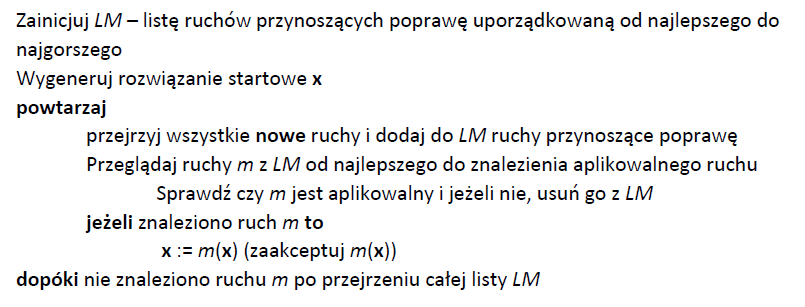

In [29]:
def look_for_better_moves(matrix, moves_list, last_move, visited_1, visited_2):
  if len(moves_list) > 0:
    for vertex in last_move:
      # print('func', moves_list)
      # TODO: czy powinniśmy robić update wartości ruchu? bo w teorii dopiero potem sprawdzamy, czy rzeczywiscie jest wart?
      moves_list = sort_dict({**moves_list, **(check_for_vertice(matrix, vertex, visited_1, visited_2))})
    
    return moves_list

  else:
    moves_list = check_for_change_edges_in_one(matrix, visited_1)
    moves_list = sort_dict({**moves_list, **(check_for_change_vertices_in_one(matrix, visited_1))})
    moves_list = sort_dict({**moves_list, **(check_for_change_edges_in_one(matrix, visited_2))})
    moves_list = sort_dict({**moves_list, **(check_for_change_vertices_in_one(matrix, visited_2))})
    moves_list = sort_dict({**moves_list, **(check_for_change_vertices(matrix, visited_1, visited_2))})

  return moves_list

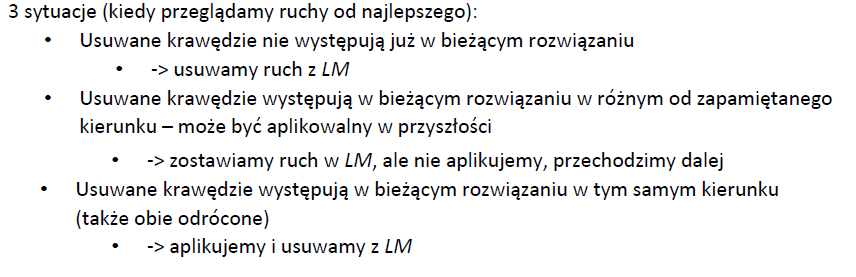

In [30]:
lista = [1,2,3,4,5,6,7]

In [31]:
def steepest_list_better_moves(matrix, visited_1, visited_2):
  # od najlepszego do najgorszego
  moves_list = {}
  # index ruchu do wykonania
  next_move = -2

  i = 0
  while next_move is not None and i <2000:
    i += 1
    moves_list = look_for_better_moves(matrix, moves_list, next_move, visited_1, visited_2)
    
    next_move = None
    
    for key, value in list(moves_list.items()):
      # print(key, value)
      if value:
        for move in value:
          if next_move is not None:
          # TODO: przejrzeć cały słownik do końca i usunąć ruchy związane z tymi wierzchołkami
            for elem in move:
              if elem in next_move:
                if key in moves_list and value.remove(move) is None:
                  moves_list.pop(key)
                else:
                  moves_list[key] = value
                break
          # break


          # print(move, value, moves_list[key])
          if len(move) == 4:

            # krawędzie, które można zastosować teraz
            if set(move).issubset(visited_1):
              visited = visited_1
            elif set(move).issubset(visited_1):
              visited = visited_2
            else:
              visited = None
            
            if visited is not None:
              if ((visited.index(move[0]) < visited.index(move[1]) and visited.index(move[2]) < visited.index(move[3])) \
                or (visited.index(move[0]) > visited.index(move[1]) and visited.index(move[2]) > visited.index(move[3]))) \
                and visited.index(move[1]) != 0 and visited.index(move[2]) != 0 and visited.index(move[1]) != -1 and visited.index(move[2]) != -1:

                # odwrócić listę pomiędzy indeksami 1 i 2
                if visited == visited_1:
                  if visited.index(move[0]) < visited.index(move[1]):
                    index_prev = visited_1.index(move[1])
                    index_next = visited_1.index(move[3])
                  else:
                    index_prev = visited_1.index(move[0])
                    index_next = visited_1.index(move[2])

                  visited_1[index_prev:index_next] = visited_1[index_prev:index_next:-1]

                  visited_1[-1] = visited_1[0]

                else:
                  if visited.index(move[0]) < visited.index(move[1]):
                    index_prev = visited_1.index(move[1])
                    index_next = visited_1.index(move[3])
                  else:
                    index_prev = visited_1.index(move[0])
                    index_next = visited_1.index(move[2])

                  visited_2[index_prev:index_next] = visited_2[index_prev:index_next:-1]

                  visited_2[-1] = visited_2[0]

                next_move = move
                if key in moves_list and value.remove(move) is None:
                  moves_list.pop(key)
                else:
                  moves_list[key] = value
                break

            # krawędzie, które nie znajdują się w tych samych pętlach lub nie następują po sobie
            else:
              if key in moves_list and value.remove(move) is None:
                moves_list.pop(key)
              else:
                moves_list[key] = value

          else:
            if move[0] in visited_1:
              visited = visited_1
            elif move[0] in visited_2:
              visited = visited_2
            
            index = visited.index(move[0])
            next_item = visited[index + 1]
            prev_item = visited[index - 1]

            if move[1] in visited_1:
              visited = visited_1
            elif move[1] in visited_2:
              visited = visited_2
            
            index_2 = visited.index(move[1])
            next_item_2 = visited[index_2 + 1]
            prev_item_2 = visited[index_2 - 1]

            if next_item != move[1] and prev_item != move[1] and next_item_2 != move[0] and prev_item_2 != move[0]:

              if move[1] in visited_1:

                if move[0] in visited_1:
                  if visited_1.index(move[0]) == 0:
                    visited_1[-1] = move[1]

                  elif visited_1.index(move[1]) == 0:
                    visited_1[-1] = move[0]

                  visited_1[visited_1.index(move[0])] = move[1]
                  visited_1[visited_1.index(move[1])] = move[0]

                else:
                  if visited_2[0] == move[0]:
                    visited_2[-1] = move[1]
                    visited_2[0] = move[1]
                  else:
                    visited_2[visited_2.index(move[0])] = move[1]

                  if visited_1[0] == move[1]:
                    visited_1[-1] = move[0]
                    visited_1[0] = move[0]
                  else:
                    visited_1[visited_1.index(move[1])] = move[0]

              else:
                if move[0] in visited_1:
                  if visited_1[0] == move[0]:
                    visited_1[-1] = move[1]
                    visited_1[0] = move[1]
                  else:
                    visited_1[visited_1.index(move[0])] = move[1]

                  if visited_2[0] == move[1]:
                    visited_2[-1] = move[0]
                    visited_2[0] = move[0]
                  else:
                    visited_2[visited_2.index(move[1])] = move[0]

                else:
                  if visited_2.index(move[0]) == 0:
                    visited_2[-1] = move[1]
                  elif visited_2.index(move[1]) == 0:
                    visited_2[-1] = move[0]

                  visited_2[visited_2.index(move[0])] = move[1]
                  visited_2[visited_2.index(move[1])] = move[0]

              next_move = move
              if key in moves_list and value.remove(move) is None:
                moves_list.pop(key)
              else:
                moves_list[key] = value
              break
              
        if len(set(visited_1)) != 100 or  len(set(visited_2)) != 100:
          visited_1[-1] = visited_1[0]
          visited_2[-1] = visited_2[0]

  print(i)
  return visited_1, visited_2

len of list: 202 , len of visited_1: 101 , len of visited_2: 101
100 100


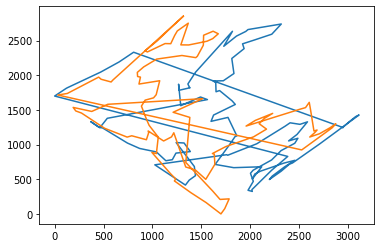

3
100 100
delta: 0 , len of final_visited_1: 101 , len of final_visited_2: 101


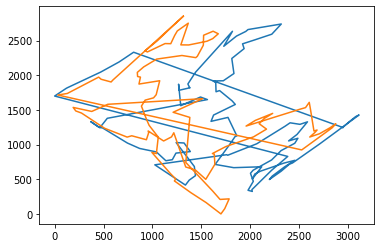

In [32]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

# visited_1, visited_2 = generate_random(matrix, 0)
visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
# skorzystamy z zamiany wierzchołków, bo była szybsza...
# steepest_change_vertices(matrix, np.array(visited_1), np.array(visited_2))

start_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
print('len of list:', len(np.concatenate([visited_1, visited_2])), ', len of visited_1:', len(visited_1),  ', len of visited_2:', len(visited_2))
print(len(set(visited_1)), len(set(visited_2)))
draw_plot(matrix, [visited_1, visited_2])

final_visited_1, final_visited_2 = steepest_list_better_moves(matrix, list(visited_1), list(visited_2))
sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

print(len(set(final_visited_1)), len(set(final_visited_2)))
print('delta:', start_sum - sum, ', len of final_visited_1:', len(final_visited_1),  ', len of final_visited_2:', len(final_visited_2))
draw_plot(matrix, [final_visited_1, final_visited_2])

### Candidate movements

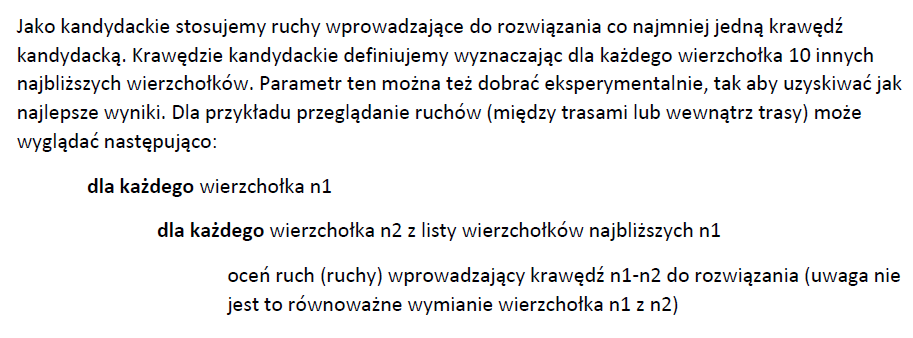

#### Helper function

In [33]:
# zamiana wierzhołków MIĘDZY grafami
def steepest_change_vertices_outer_nearest(matrix, visited_1, visited_2, nearest):
  best = -np.inf
  vertex_to_change = []

  for first in range(len(visited_1) - 1):
    temp = [value for value in nearest[first] if value in visited_2[:-1]]
    for value in temp: 
      second = np.where(visited_2 == value)[0][0]
      first_pre,first_next = first-1,first+1
      second_pre,second_next = second-1,second+1
      if (first == 0):
        first_pre = first-2
      if (second == 0):
        second_pre = second-2
      previous = matrix[visited_1[first], visited_1[first_pre]] +\
                 matrix[visited_1[first], visited_1[first_next]] +\
                 matrix[visited_2[second], visited_2[second_pre]] +\
                 matrix[visited_2[second], visited_2[second_next]]
                 
      next = matrix[visited_2[second], visited_1[first_pre]] +\
             matrix[visited_2[second], visited_1[first_next]] +\
             matrix[visited_1[first], visited_2[second_pre]] +\
             matrix[visited_1[first], visited_2[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        vertex_to_change = [visited_1[first], visited_2[second]]
  
  if (best <= 0):
    return

  visited_1[np.where(visited_1 == vertex_to_change[0])[0][0]] = vertex_to_change[1]
  visited_2[np.where(visited_2 == vertex_to_change[1])[0][0]] = vertex_to_change[0]

In [34]:
# zamiana wierzhołków WEWNĄTRZ grafu
def steepest_change_vertices_inner_nearest(matrix, visited, nearest):
  best = -np.inf
  vertex_to_change = []
  for first in range(len(visited) - 2): 
    temp = [value for value in nearest[first] if value in visited[first + 1:len(visited) - 1]]
    for value in temp: 
      second = np.where(visited == value)[0][0]
      first_pre,first_next = first-1,first+1
      second_pre,second_next = second-1,second+1
      if (first == 0):
        first_pre = first-2
      if (first_next == second): # warunek sąsiedztwa
        previous = matrix[visited[first], visited[first_pre]] +\
                  matrix[visited[first], visited[second]] +\
                  matrix[visited[second], visited[first]] +\
                  matrix[visited[second], visited[second_next]]
        next = matrix[visited[second], visited[first_pre]] +\
              matrix[visited[second], visited[first]] +\
              matrix[visited[first], visited[second]] +\
              matrix[visited[first], visited[second_next]]
      else:
        previous = matrix[visited[first], visited[first_pre]] +\
                  matrix[visited[first], visited[first_next]] +\
                  matrix[visited[second], visited[second_pre]] +\
                  matrix[visited[second], visited[second_next]]
        next = matrix[visited[second], visited[first_pre]] +\
              matrix[visited[second], visited[first_next]] +\
              matrix[visited[first], visited[second_pre]] +\
              matrix[visited[first], visited[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        vertex_to_change = [visited[first], visited[second]]
  if (best <= 0):
    return

  visited[np.where(visited == vertex_to_change[0])[0][0]] = vertex_to_change[1] 
  visited[np.where(visited == vertex_to_change[1])[0][0]] = vertex_to_change[0]

In [35]:
# zamiana krawędzi WEWNĄTRZ grafu
def steepest_change_edges_inner_nearest(matrix, visited, nearest):
  best = -np.inf
  index_to_change = []
  for first in range(len(visited) - 2):
    temp = [value for value in nearest[first] if value in visited[first + 2: len(visited) - 1]]
    for value in temp: 
      second = np.where(visited == value)[0][0]
      first_next = first+1
      second_next = second+1
      if (visited[first] == visited[second_next]):
        continue

      previous = matrix[visited[first], visited[first_next]] +\
                matrix[visited[second], visited[second_next]]
      next = matrix[visited[first], visited[second]] +\
            matrix[visited[first_next], visited[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        index_to_change = [first_next, second_next]
        
  if (best <= 0):
    return
  
  visited[index_to_change[0]:index_to_change[1]] = visited[index_to_change[0]:index_to_change[1]][::-1]

#### Steepest algorithm

In [36]:
def steepest_candidate_movements(matrix, visited_1, visited_2, k = 10):

  nearest_matrix = np.zeros((len(matrix), k))

  for vertex in range(len(matrix)):
    temp = sorted(matrix[vertex])[1:k+1]
    
    i = 0
    for index, value in enumerate(temp):
      if i > len(np.where(matrix[vertex] == value)[0]):
        i = 0
      if len(np.where(matrix[vertex] == value)[0]) == 1:
        nearest_matrix[vertex][index] = np.where(matrix[vertex] == value)[0]
      else:
        nearest_matrix[vertex][index] = np.where(matrix[vertex] == value)[0][i]
        
  # inner graph 1
  while True:
    previous = calculate_cycle_length(matrix,[visited_1])
    steepest_change_edges_inner_nearest(matrix, visited_1, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_1])
    if (next >= previous):
      break

  # inner graph 2
  while True:
    previous = calculate_cycle_length(matrix,[visited_2])
    steepest_change_edges_inner_nearest(matrix, visited_2, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_2])
    if (next >= previous):
      break

  # outer graphs
  while True:
    previous = calculate_cycle_length(matrix,[visited_1,visited_2])
    steepest_change_vertices_outer_nearest(matrix, visited_1, visited_2, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_1,visited_2])
    if (next >= previous):
      break

  return visited_1, visited_2

len of list: 202 , len of visited_1: 101 , len of visited_2: 101
100 100


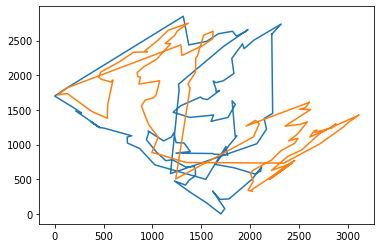

100 100
delta: 408 , len of final_visited_1: 101 , len of final_visited_2: 101


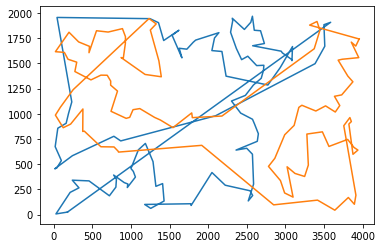

In [37]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
# skorzystamy z zamiany wierzchołków, bo była szybsza...
# steepest_change_vertices(matrix, np.array(visited_1), np.array(visited_2))

start_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
print('len of list:', len(np.concatenate([visited_1, visited_2])), ', len of visited_1:', len(visited_1),  ', len of visited_2:', len(visited_2))
print(len(set(visited_1)), len(set(visited_2)))
draw_plot(matrix, [visited_1, visited_2])

final_visited_1, final_visited_2 = steepest_candidate_movements(matrix, visited_1, visited_2)
sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

print(len(set(final_visited_1)), len(set(final_visited_2)))
print('delta:', start_sum - sum, ', len of final_visited_1:', len(final_visited_1),  ', len of final_visited_2:', len(final_visited_2))
draw_plot(verticesA, [final_visited_1, final_visited_2])

#### Stepest algorithm v2 (wszystkie inner)

In [38]:
def steepest_candidate_movements_vertices(matrix, visited_1, visited_2, k = 10):

  nearest_matrix = np.zeros((len(matrix), k))

  for vertex in range(len(matrix)):
    temp = sorted(matrix[vertex])[1:k+1]
    
    i = 0
    for index, value in enumerate(temp):
      if i > len(np.where(matrix[vertex] == value)[0]):
        i = 0
      if len(np.where(matrix[vertex] == value)[0]) == 1:
        nearest_matrix[vertex][index] = np.where(matrix[vertex] == value)[0]
      else:
        nearest_matrix[vertex][index] = np.where(matrix[vertex] == value)[0][i]
        


  # inner graph 1
  while True:
    previous = calculate_cycle_length(matrix,[visited_1])
    steepest_change_vertices_inner_nearest(matrix, visited_1, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_1])
    if (next >= previous):
      break

  # inner graph 2
  while True:
    previous = calculate_cycle_length(matrix,[visited_2])
    steepest_change_vertices_inner_nearest(matrix, visited_2, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_2])
    if (next >= previous):
      break

  # outer graphs
  while True:
    previous = calculate_cycle_length(matrix,[visited_1,visited_2])
    steepest_change_vertices_outer_nearest(matrix, visited_1, visited_2, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_1,visited_2])
    if (next >= previous):
      break

  return visited_1, visited_2

len of list: 202 , len of visited_1: 101 , len of visited_2: 101
100 100


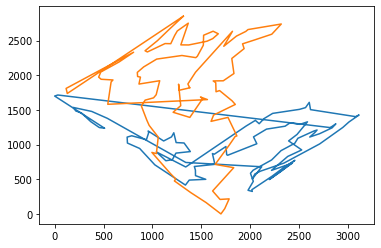

100 100
delta: 0 , len of final_visited_1: 101 , len of final_visited_2: 101


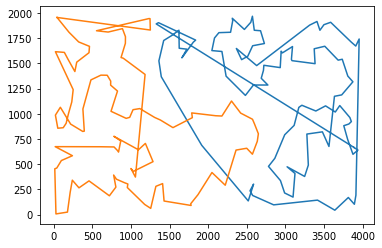

In [39]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
# skorzystamy z zamiany wierzchołków, bo była szybsza...
# steepest_change_vertices(matrix, np.array(visited_1), np.array(visited_2))

start_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
print('len of list:', len(np.concatenate([visited_1, visited_2])), ', len of visited_1:', len(visited_1),  ', len of visited_2:', len(visited_2))
print(len(set(visited_1)), len(set(visited_2)))
draw_plot(matrix, [visited_1, visited_2])

final_visited_1, final_visited_2 = steepest_candidate_movements_vertices(matrix, visited_1, visited_2)
sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

print(len(set(final_visited_1)), len(set(final_visited_2)))
print('delta:', start_sum - sum, ', len of final_visited_1:', len(final_visited_1),  ', len of final_visited_2:', len(final_visited_2))
draw_plot(verticesA, [final_visited_1, final_visited_2])

## Algorithms - Exercise 4 - Multiple start local search

### Multiple start local search

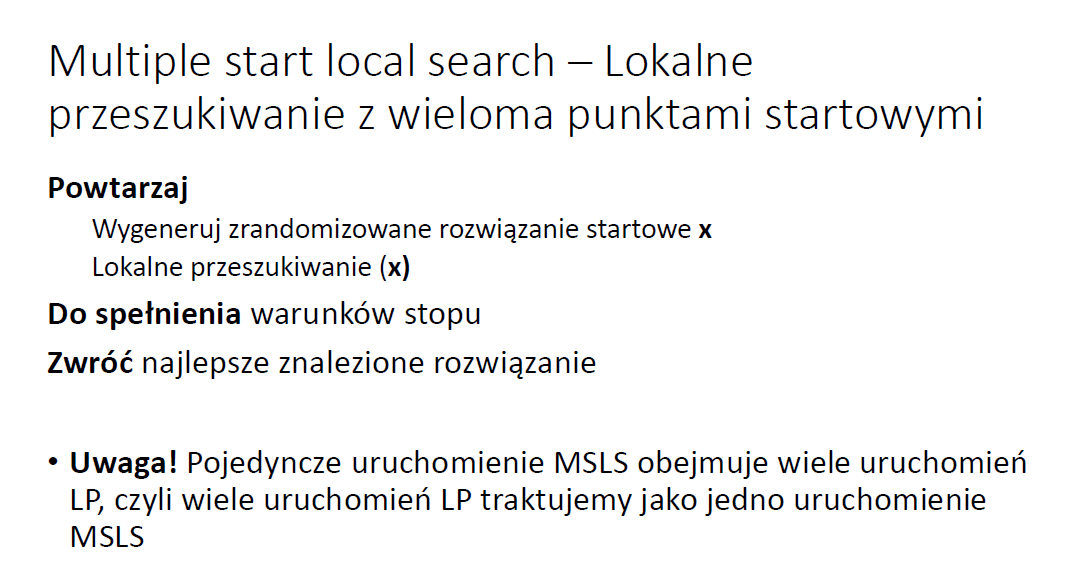

In [40]:
def multiple_start_local_search(matrix, numIteration = 100):
  i = 0
  global_sum = np.inf
  final_visited_1, final_visited_2 = [], []
  
  # stop condition => 100 iterations
  while i < numIteration:

    # generate random start solution
    start_vertice = randint(0, len(matrix) - 1)
    visited_1, visited_2 = greedy_cycle(matrix, start_vertice)

    # Local search 
    # steepest_change_vertices(matrix, visited_1, visited_2)
    visited_1, visited_2 = greedy_change_vertices(matrix, visited_1, visited_2)
    sum = calculate_cycle_length(matrix, [visited_1, visited_2])

    # check if it's better than last
    if (sum < global_sum):
      global_sum = sum
      final_visited_1, final_visited_2 = visited_1, visited_2

    i += 1

  return final_visited_1, final_visited_2

### Iterated Local Search

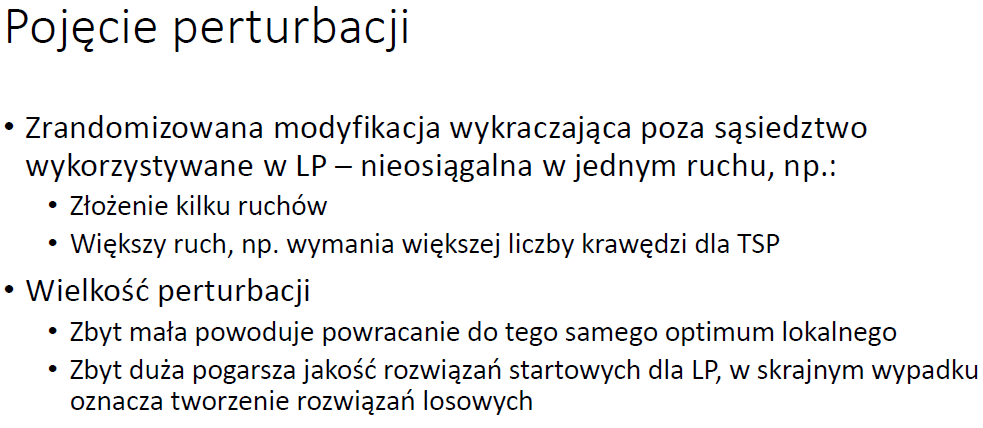

#### Helper functions

In [41]:
def change_solution(visited_1, visited_2):
  first = randint(0, len(visited_1) - 1)
  second = randint(0, len(visited_2) - 1)

  visited_1[first], visited_2[second] = visited_2[second], visited_1[first]

  return visited_1, visited_2

In [42]:
def check_for_best_move(matrix, item, visited):
  min_value = np.inf
  min_index = None

  for i, vertex in enumerate(visited[0:-1]):
    temp_sum = matrix[vertex][item] + matrix[visited[i + 1]][item]

    if temp_sum < min_value:
      min_value = temp_sum
      min_index = i + 1

  return min_index

In [43]:
def rebuilt_solution(matrix, visited_1, visited_2, deleted_vertices):

  if visited_1[0] != visited_1[-1]:
    visited_1 = np.append(visited_1, visited_1[0])

  if visited_2[0] != visited_2[-1]:
    visited_2 = np.append(visited_2, visited_2[0])

  for elem in deleted_vertices:
    if len(visited_2) < len(visited_1):
      visited_2 = np.insert(visited_2, check_for_best_move(matrix, elem, visited_2), elem)
    else:
      visited_1 = np.insert(visited_1, check_for_best_move(matrix, elem, visited_1), elem)
  
  return visited_1, visited_2

#### Iterated local search 1

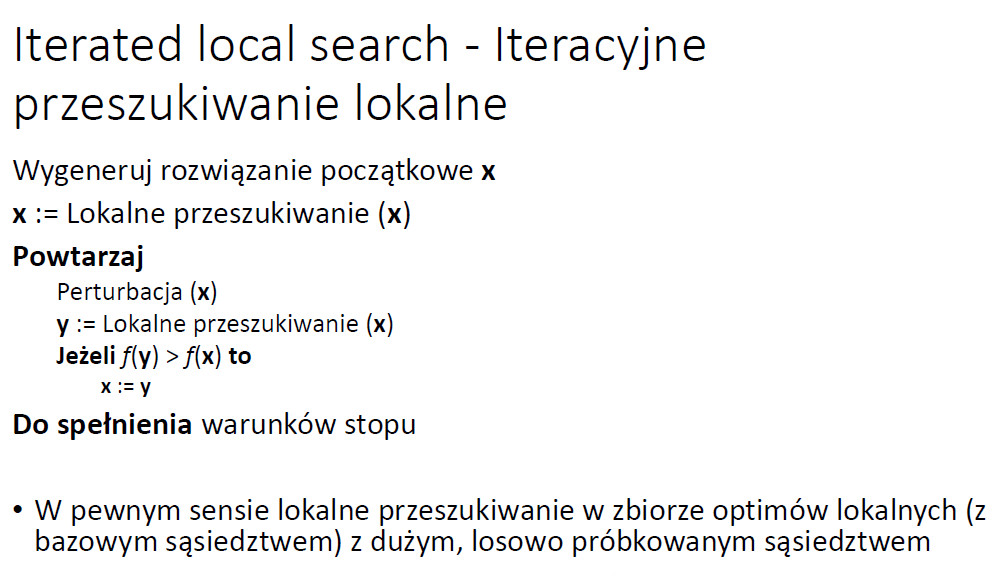

In [44]:
def iterated_start_local_search_1(matrix, iterationNumChange=5, avgTime=919.5): # 9.5): # 
  
  start_vertice = randint(0, len(matrix) - 1)
  visited_1, visited_2 = greedy_cycle(matrix, start_vertice)
  steepest_change_vertices(matrix, visited_1, visited_2)
  global_sum = calculate_cycle_length(matrix, [visited_1, visited_2])

  start = time.time()
  end = time.time()

  while (end - start) < avgTime:
    # rozpoczynamy perturbacje od najlepszego do tej pory
    temp_visited_1, temp_visited_2 = np.copy(visited_1), np.copy(visited_2)

    # simple perturabtion
    for i in range(0, iterationNumChange):
      temp_visited_1, temp_visited_2 = change_solution(temp_visited_1, temp_visited_2)

    # Local Search
    temp_visited_1, temp_visited_2 = greedy_change_vertices(matrix, temp_visited_1, temp_visited_2)
    #steepest_change_vertices(matrix, temp_visited_1, temp_visited_2)
    
    sum = calculate_cycle_length(matrix, [temp_visited_1, temp_visited_2])

    if (sum < global_sum):
      global_sum = sum
      visited_1, visited_2 = temp_visited_1, temp_visited_2
    
    end = time.time()
    
  return visited_1, visited_2

#### Iterated local search 2 (Large-scale neighborhood search)

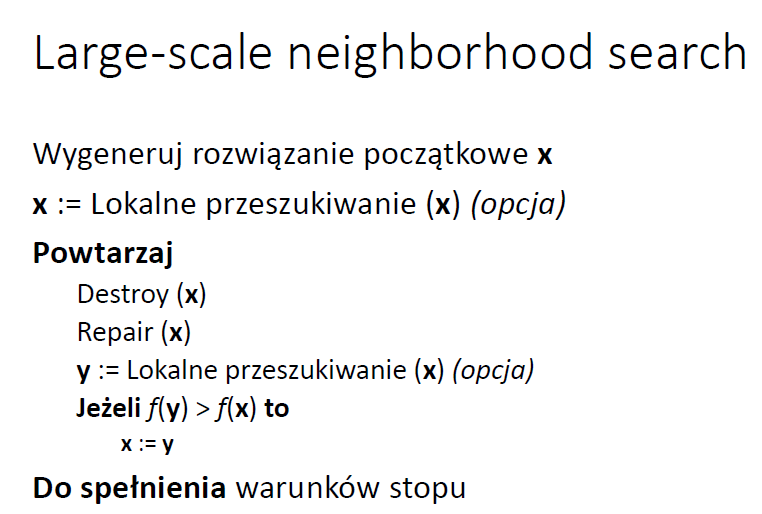

In [45]:
def iterated_start_local_search_2(matrix, rebuildSize = 0.2, avgTime = 919.5):
  if rebuildSize > 1.0:
    print('Error rebuilt size must be <= 1.')
    rebuildSize = 0.2
 
  start_vertice = randint(0, len(matrix) - 1)
  visited_1, visited_2 = greedy_cycle(matrix, start_vertice)
  # steepest_change_vertices(matrix, visited_1, visited_2)
  global_sum = calculate_cycle_length(matrix, [visited_1, visited_2])

  start = time.time()
  end = time.time()

  while (end - start) < avgTime:
    # rozpoczynamy perturbacje od najlepszego do tej pory
    temp_visited_1, temp_visited_2 = np.copy(visited_1), np.copy(visited_2)
    deleted_vertices = []

    # destroy solution - perturbacja
    while len(temp_visited_1) + len(temp_visited_2) >= (1 - rebuildSize) * len(matrix):
      if len(temp_visited_1) > len(temp_visited_2): 
        delete_vertice = randint(0, len(temp_visited_1) - 1)
        deleted_vertices.append(temp_visited_1[delete_vertice])
        temp_visited_1 = np.delete(temp_visited_1, delete_vertice)

      else:
        delete_vertice = randint(0, len(temp_visited_2) - 1)
        deleted_vertices.append(temp_visited_2[delete_vertice])
        temp_visited_2 = np.delete(temp_visited_2, delete_vertice)

    # repair solution
    temp_visited_1, temp_visited_2 = rebuilt_solution(matrix, temp_visited_1, temp_visited_2, deleted_vertices)

    # Local Search
    # steepest_change_vertices(matrix, temp_visited_1, temp_visited_2)
    temp_visited_1, temp_visited_2 = greedy_change_vertices(matrix, temp_visited_1, temp_visited_2)
    
    sum = calculate_cycle_length(matrix, [temp_visited_1, temp_visited_2])

    if (sum < global_sum):
      global_sum = sum
      visited_1, visited_2 = temp_visited_1, temp_visited_2
    
    end = time.time()
    
  return visited_1, visited_2

## Tests (x 10)

### Testy dla MSLS

Min_value : 35029
Max_value : 35382
Average : 35239.1
Average time: 916.84197742939
Min time: 905.8645758628845
Max time: 928.6746718883514
Calculated min:  35029


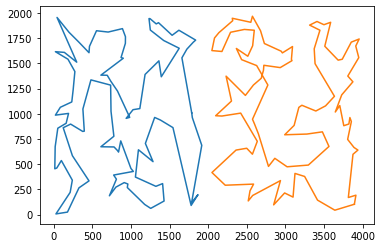

101 101


In [47]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 10):
  start = time.time()
  visited_1, visited_2 = multiple_start_local_search(matrix)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])

  if (sum < min_value):
    min_value = sum
    final_first_sum = sum
    min_solution = [visited_1, visited_2]

  if (sum > max_value):
    max_value = sum

  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(verticesA, min_solution)

print(len(min_solution[0]), len(min_solution[1]))

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 10):
  start = time.time()
  visited_1, visited_2 = multiple_start_local_search(matrix)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])

  if (sum < min_value):
    min_value = sum
    final_first_sum = sum
    min_solution = [visited_1, visited_2]

  if (sum > max_value):
    max_value = sum

  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(verticesB, min_solution)

print(len(min_solution[0]), len(min_solution[1]))

### Testy dla ILS1

Min_value : 33639
Max_value : 38713
Average : 36671.1
Average time: 926.3480662822724
Min time: 925.8284993171692
Max time: 926.6197485923767
Calculated min:  33639


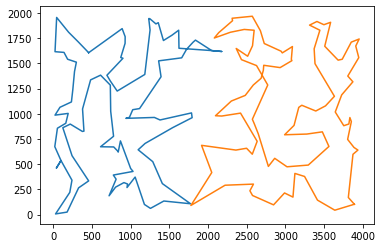

101 101


In [50]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesA)

for i in range(0, 10):
  start = time.time()
  visited_1, visited_2 = iterated_start_local_search_1(matrix, 5, 916.84)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])

  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]

  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(verticesA, min_solution)

print(len(min_solution[0]), len(min_solution[1]))

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesB)

for i in range(0, 10):
  start = time.time()
  visited_1, visited_2 = iterated_start_local_search_1(matrix)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])

  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]

  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(verticesB, min_solution)

print(len(min_solution[0]), len(min_solution[1]))

### Testy dla ILS2

Min_value : 35464
Max_value : 39751
Average : 38834.5
Average time: 925.9675523996353
Min time: 925.3962445259094
Max time: 926.1678838729858
Calculated min:  35464


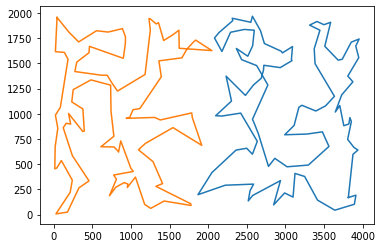

101 101


In [51]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesA)

for i in range(0, 10):
  start = time.time()
  visited_1, visited_2 = iterated_start_local_search_2(matrix, 0.2, 916.84)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])

  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]

  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(verticesA, min_solution)

print(len(min_solution[0]), len(min_solution[1]))

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []

matrix = distance_matrix(verticesB)

for i in range(0, 10):
  start = time.time()
  visited_1, visited_2 = iterated_start_local_search_2(matrix)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])

  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]

  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
draw_plot(verticesB, min_solution)

print(len(min_solution[0]), len(min_solution[1]))